# Credit Risk Analysis and prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.metrics import confusion_matrix, precision_recall_curve, fbeta_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from xgboost import XGBClassifier

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

pd.set_option('display.max_columns', 100)

In [4]:
df_labelled = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/credit_risk/credit_risk_labelled.csv", index_col=[0])
df_unlabelled = pd.read_csv("/Users/victor_03/Documents/DataScience/Kaggle/credit_risk/credit_risk_unlabelled.csv", index_col=[0])

In [5]:
df_labelled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
df_unlabelled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [7]:
df_unlabelled == df_test

NameError: name 'df_test' is not defined

The labelled and unlabelled set are similar, except for the 'NaN' values, that we will fill soon

In [8]:
df = df_labelled

## Filling missing data

In [9]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [10]:
print(df['Saving accounts'].unique())
df['Saving accounts'][df['Saving accounts'].isna()] = 'None'
print(df['Saving accounts'].unique())

[nan 'little' 'quite rich' 'rich' 'moderate']
['None' 'little' 'quite rich' 'rich' 'moderate']


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
print(df['Checking account'].unique())
df['Checking account'][df['Checking account'].isna()] = 'None'
print(df['Checking account'].unique())

['little' 'moderate' nan 'rich']
['little' 'moderate' 'None' 'rich']


/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [13]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

## Data Analysis

proportion of good credit:  0.7
proportion of bad credit:  0.3


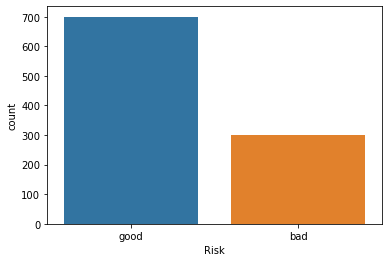

In [14]:
sns.countplot(x=df['Risk'])
print('proportion of good credit: ', sum(sum([df['Risk']=='good']))/len(df))
print('proportion of bad credit: ', sum(sum([df['Risk']=='bad']))/len(df))

70% of the credits in the dataset are labelled 'bad'

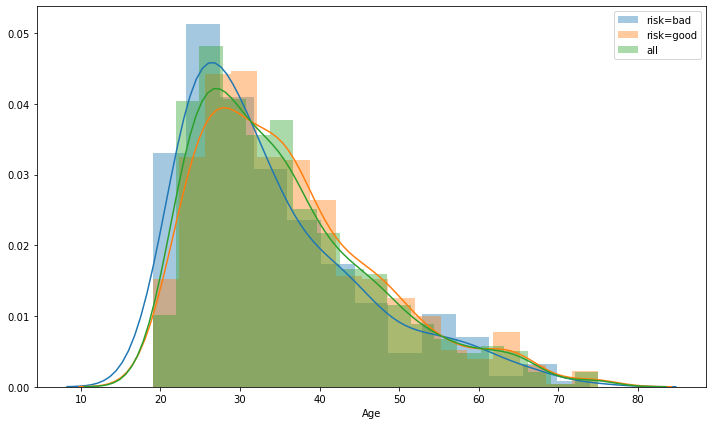

In [15]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Age'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Age'][df['Risk']=='good'], label = 'risk=good')
sns.distplot(df['Age'], label='all')
plt.legend()

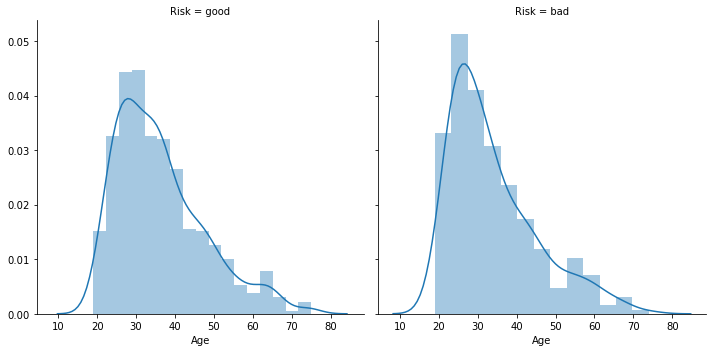

In [16]:
g = sns.FacetGrid(df, col="Risk", height=5, aspect=1)
g.map(sns.distplot, "Age")

 Younger people appear to be more at risk for bad credit than older people

proportion of fail for category 0: 31.8%
proportion of fail for category 1: 28.0%
proportion of fail for category 2: 29.5%
proportion of fail for category 3: 34.5%


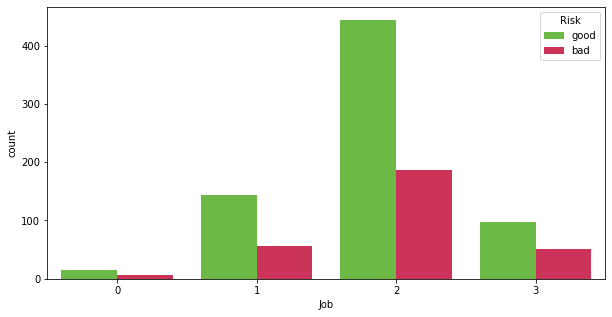

In [17]:
plt.figure(figsize = (10, 5))
sns.countplot(data=df, x='Job', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])
categories = df['Job'].unique()
categories.sort()

for category in categories:
    fail = len((df)[(df['Job']==category) & (df['Risk']=='bad')]) / len((df)[(df['Job']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

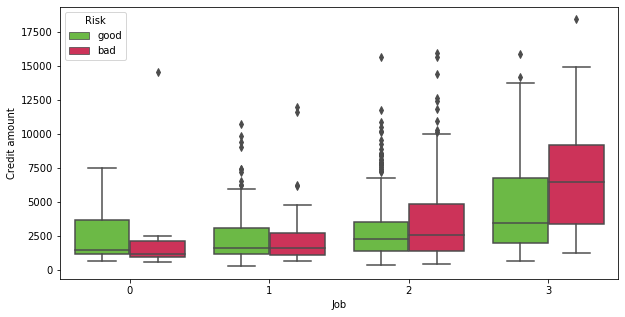

In [18]:
plt.figure(figsize = (10, 5))
sns.boxplot(data=df, x='Job', y='Credit amount', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

Most of the credits are made by people in job category 2, but the proportion of bad credits is similar for each category  
Nonetheless, the highest credits are made by job category 3, and the largest variation is made by category 0   
People in category 3 fail more often

proportion of fail for category own: 26.1%
proportion of fail for category free: 40.7%
proportion of fail for category rent: 39.1%


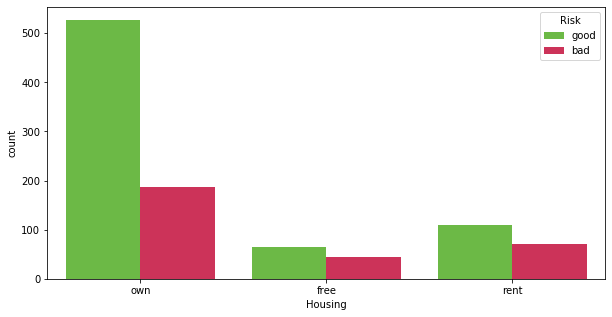

In [19]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Housing', hue='Risk', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Housing'].unique()
for category in categories:
    fail = len((df)[(df['Housing']==category) & (df['Risk']=='bad')]) / len((df)[(df['Housing']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

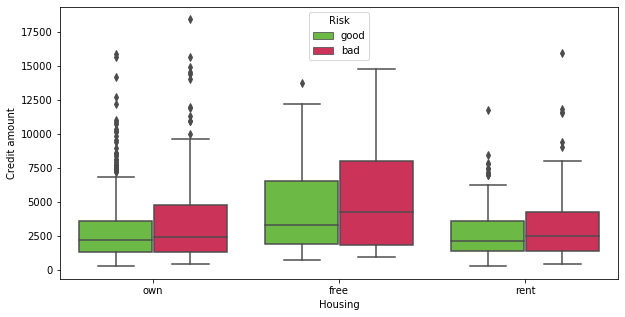

In [20]:
plt.figure(figsize = (10, 5))
sns.boxplot(x='Housing', hue='Risk', y='Credit amount', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

People owning their own house tend to make more credits, and have a lower proportion of fail  
Those who are free housing make larger credits

proportion of fail for category None: 17.5%
proportion of fail for category little: 36.0%
proportion of fail for category quite rich: 17.5%
proportion of fail for category rich: 12.5%
proportion of fail for category moderate: 33.0%


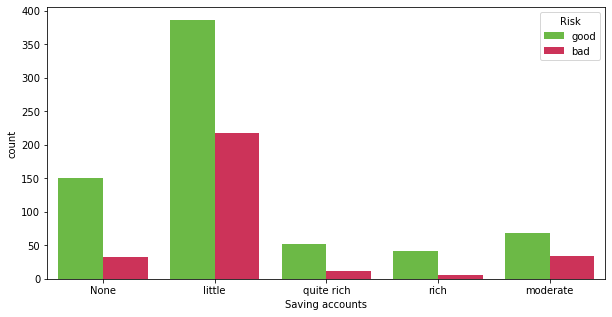

In [21]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Saving accounts', hue='Risk', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Saving accounts'].unique()
for category in categories:
    fail = len((df)[(df['Saving accounts']==category) & (df['Risk']=='bad')]) / len((df)[(df['Saving accounts']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

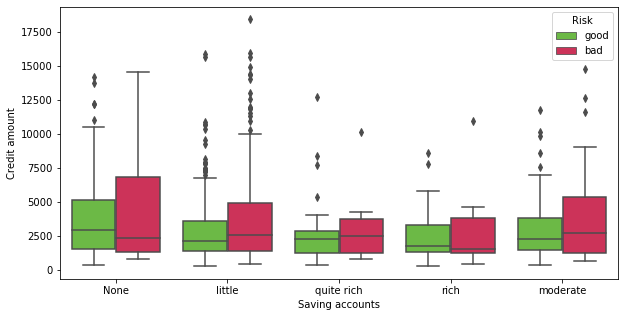

In [22]:
plt.figure(figsize = (10, 5))
sns.boxplot(x='Saving accounts', hue='Risk', y='Credit amount', data=df, palette=[(.4, .8, .2), (.9, .1, .3)])

People with little saving account make more credits than other categories, with a higher proportion a failing.  
Poeple with moderate saving fail quite often as well.  
Nonetheless, each category makes credit of similar amount.  
Rich people have a larger variation, meaning they are more susceptible to borrow large amounts

proportion of fail for category radio/TV: 22.1%
proportion of fail for category education: 39.0%
proportion of fail for category furniture/equipment: 32.0%
proportion of fail for category car: 31.5%
proportion of fail for category business: 35.1%
proportion of fail for category domestic appliances: 33.3%
proportion of fail for category repairs: 36.4%
proportion of fail for category vacation/others: 41.7%


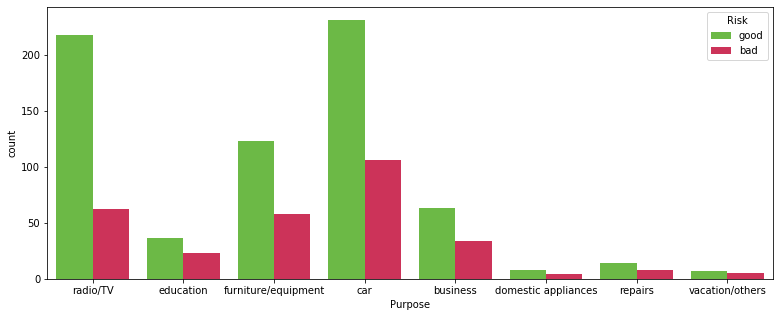

In [23]:
plt.figure(figsize = (13, 5))
sns.countplot(data=df, x='Purpose', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Purpose'].unique()
for category in categories:
    fail = len((df)[(df['Purpose']==category) & (df['Risk']=='bad')]) / len((df)[(df['Purpose']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

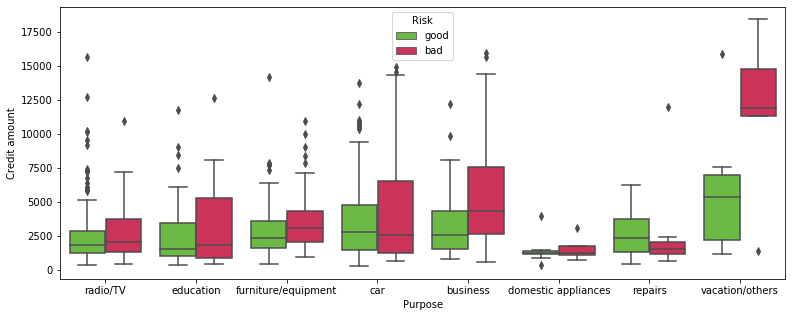

In [24]:
plt.figure(figsize = (13, 5))
sns.boxplot(data=df, x='Purpose', hue='Risk', y='Credit amount', palette=[(.4, .8, .2), (.9, .1, .3)])

Very interesting plot, as credits made for vacation have the largest proportion of failing. 
Business is second in raking of failing purpose  
People tend to make more credits to buy radio/TV and cars.  
Every category is more susceptible to lead to a failing credit than to success...

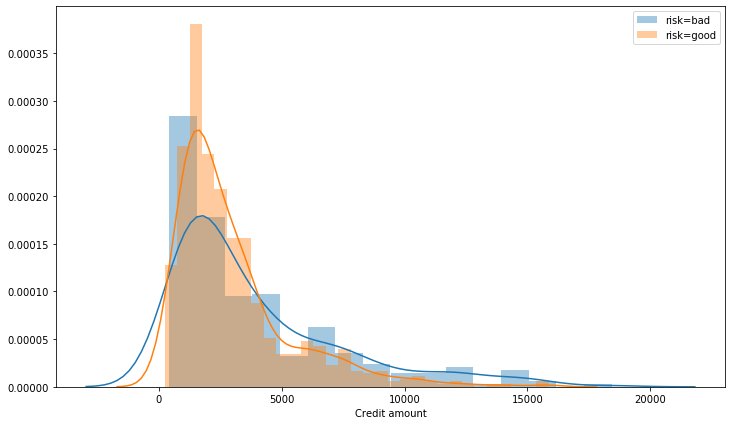

In [25]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Credit amount'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Credit amount'][df['Risk']=='good'], label = 'risk=good')
plt.legend()

High credit amounts fail more often than low credit. 

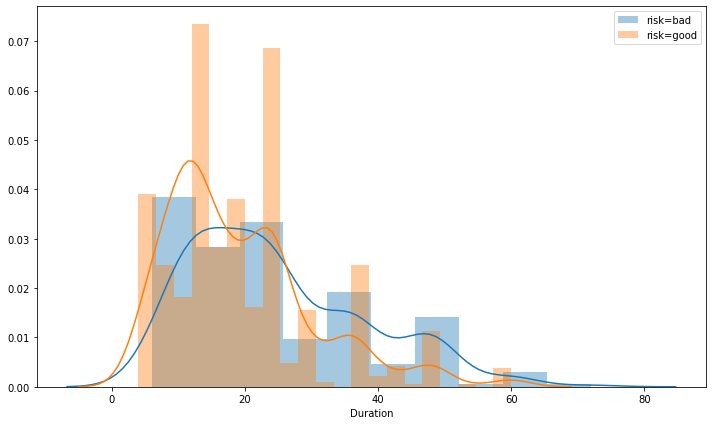

In [26]:
plt.figure(figsize = (12, 7))
sns.distplot(df['Duration'][df['Risk']=='bad'], label = 'risk=bad')
sns.distplot(df['Duration'][df['Risk']=='good'], label = 'risk=good')
plt.legend()

Credits engaged on a long duration happen to fail more than on short duration, which follows the previous plot: larger credits lead to longer duration, hence failing more ofter

proportion of fail for category male: 27.7%
proportion of fail for category female: 35.2%


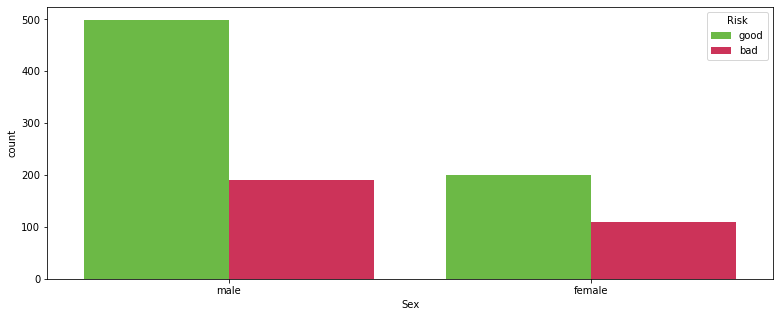

In [27]:
plt.figure(figsize = (13, 5))
sns.countplot(data=df, x='Sex', hue='Risk', palette=[(.4, .8, .2), (.9, .1, .3)])

categories = df['Sex'].unique()
for category in categories:
    fail = len((df)[(df['Sex']==category) & (df['Risk']=='bad')]) / len((df)[(df['Sex']==category)])
    print('proportion of fail for category {}: {}%'.format(category, round(fail*100, 1)))

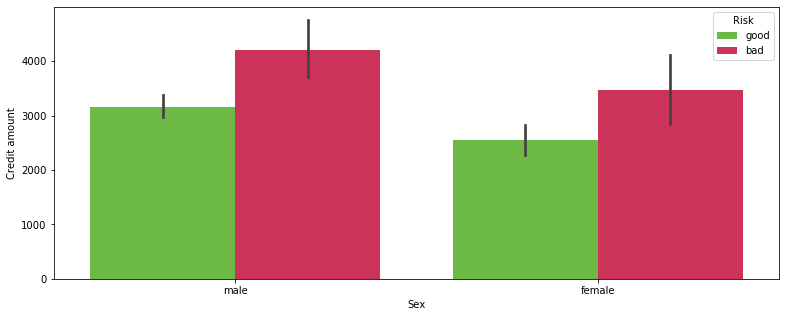

In [28]:
plt.figure(figsize = (13, 5))
sns.barplot(data=df, x='Sex', hue='Risk', y='Credit amount', palette=[(.4, .8, .2), (.9, .1, .3)])

Males engage more credits than females, but they fail less often in proportion than females  
Males also tend to borrow larger amounts, and also fail on the largest ones.  
The variation of amounts is similar for males and females

In [29]:
df_inter=pd.DataFrame()
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

for col in categorical_features:
    dummies = pd.get_dummies(df[col],prefix=col)
    df_inter = pd.concat([df_inter, dummies], axis=1)
    
df = pd.concat([df, df_inter], axis=1)
df = df.drop(categorical_features, axis=1)


    
continuous_features = ['Age', 'Credit amount', 'Duration']
for col in continuous_features:
    column = np.array(df[col])
    column = column.reshape(len(column), 1)
    sc = StandardScaler()
    sc.fit(column)
    df[col] = sc.transform(column)
    
    

y = df['Risk_good']
X=df.drop(['Risk_good', 'Risk_bad'], axis=1)

In [30]:
y = df['Risk_bad']

In [31]:
df.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent,Saving accounts_None,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_None,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad,Risk_good
0,2.766456,-0.745131,-1.236478,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,-1.191404,0.949817,2.248194,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,1.183312,-0.416562,-0.738668,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0.831502,1.634247,1.750384,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,1.535122,0.566664,0.256953,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### Find best parameters for Random Forest

In [736]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.200, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.156, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.217, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.261, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.109, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.111, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.022, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.089, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.022, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.000, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.000, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.067, total=   0.1s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.111, total=   0.1s
[CV] max_depth=3, max

[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.244, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.130, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.196, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.239, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.178, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.200, total=   0.1s
[CV] max_depth=3, max_features=15, n_estimators=50 ...................
[CV]  max_depth=3, max_features=15, n_estimators=50, score=0.152, total=   0.1s
[CV] max_depth

[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.289, total=   0.1s
[CV] max_depth=5, max_features=4, n_estimators=50 ....................
[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.174, total=   0.1s
[CV] max_depth=5, max_features=4, n_estimators=50 ....................
[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.152, total=   0.1s
[CV] max_depth=5, max_features=4, n_estimators=50 ....................
[CV]  max_depth=5, max_features=4, n_estimators=50, score=0.174, total=   0.1s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.289, total=   0.0s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.333, total=   0.0s
[CV] max_depth=5, max_features=7, n_estimators=3 .....................
[CV]  max_depth=5, max_features=7, n_estimators=3, score=0.261, total=   0.0s
[CV] max_depth=5, max_fe

[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.348, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.522, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.391, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.244, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.422, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.217, total=   0.0s
[CV] max_depth=5, max_features=20, n_estimators=5 ....................
[CV]  max_depth=5, max_features=20, n_estimators=5, score=0.370, total=   0.0s
[CV] max_depth=5, max

[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.217, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=10 ....................
[CV]  max_depth=7, max_features=7, n_estimators=10, score=0.413, total=   0.0s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.244, total=   0.1s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.400, total=   0.1s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.283, total=   0.1s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.326, total=   0.1s
[CV] max_depth=7, max_features=7, n_estimators=25 ....................
[CV]  max_depth=7, max_features=7, n_estimators=25, score=0.391, total=   0.1s
[CV] max_depth=7, max

[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.348, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=25 ...................
[CV]  max_depth=7, max_features=20, n_estimators=25, score=0.413, total=   0.1s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.311, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.467, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.370, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.326, total=   0.2s
[CV] max_depth=7, max_features=20, n_estimators=50 ...................
[CV]  max_depth=7, max_features=20, n_estimators=50, score=0.478, total=   0.2s
[CV] max_depth

[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.391, total=   0.1s
[CV] max_depth=10, max_features=7, n_estimators=50 ...................
[CV]  max_depth=10, max_features=7, n_estimators=50, score=0.435, total=   0.1s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.289, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.489, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.478, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.500, total=   0.0s
[CV] max_depth=10, max_features=15, n_estimators=3 ...................
[CV]  max_depth=10, max_features=15, n_estimators=3, score=0.457, total=   0.0s
[CV] max_depth

[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.378, total=   0.1s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.261, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.370, total=   0.1s
[CV] max_depth=None, max_features=4, n_estimators=10 .................
[CV]  max_depth=None, max_features=4, n_estimators=10, score=0.435, total=   0.0s
[CV] max_depth=None, max_features=4, n_estimators=25 .................
[CV]  max_depth=None, max_features=4, n_estimators=25, score=0.267, total=   0.1s
[CV] max_depth=None, max_features=4, n_estimators=25 .................
[CV]  max_depth=None, max_features=4, n_estimators=25, score=0.400, total=   0.1s
[CV] max_depth=None, max_features=4, n_estimators=25 .................
[CV]  max_depth=None, max_features=4, n_estimators=25, score=0.348, total=   0.1s


[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.356, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.422, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.500, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.391, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=25 ................
[CV]  max_depth=None, max_features=15, n_estimators=25, score=0.522, total=   0.1s
[CV] max_depth=None, max_features=15, n_estimators=50 ................
[CV]  max_depth=None, max_features=15, n_estimators=50, score=0.333, total=   0.2s
[CV] max_depth=None, max_features=15, n_estimators=50 ................
[CV]  max_depth=None, max_features=15, n_estimators=50, score=0.422, total= 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   31.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=2,
                                   

In [737]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.4826086956521739
{'max_depth': None, 'max_features': 20, 'n_estimators': 5}


Prediction with RF

In [751]:
rf = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=5, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [752]:
prediction = rf.predict(X_test)

In [765]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Validation of the results
print(accuracy_score(y_test,prediction))
print("\n")
print(confusion_matrix(y_test, prediction))
print("\n")
print(fbeta_score(y_test, prediction, beta=2))
print("\n")
print(classification_report(y_test, prediction))

0.716


[[150  28]
 [ 43  29]]


0.42028985507246386


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       178
           1       0.51      0.40      0.45        72

    accuracy                           0.72       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.70      0.72      0.71       250



### Test with XGBoost

In [757]:
XGBModel = XGBClassifier()
XGBModel.fit(X_train, y_train , verbose=1)

#Testing the model 
#Predicting using our  model
XGBpredictions = XGBModel.predict(X_test)

In [811]:
# Validation of the results
print(accuracy_score(y_test,XGBpredictions))
print("\n")
print(confusion_matrix(y_test, XGBpredictions))
print("\n")
print(fbeta_score(y_test, XGBpredictions, beta=2))
print("\n")
print(classification_report(y_test, XGBpredictions))

0.72


[[152  26]
 [ 44  28]]


0.40935672514619886


              precision    recall  f1-score   support

           0       0.78      0.85      0.81       178
           1       0.52      0.39      0.44        72

    accuracy                           0.72       250
   macro avg       0.65      0.62      0.63       250
weighted avg       0.70      0.72      0.71       250



### Gaussian Naive Bayes model

In [761]:
GNBModel = GaussianNB()
GNBModel.fit(X_train, y_train)

#Testing the model 
#Predicting using our  model
GNBpredictions = GNBModel.predict(X_test)

In [764]:
# Validation of the results
print(accuracy_score(y_test,GNBpredictions))
print("\n")
print(confusion_matrix(y_test, GNBpredictions))
print("\n")
print(fbeta_score(y_test, GNBpredictions, beta=2))
print("\n")
print(classification_report(y_test, GNBpredictions))

0.656


[[132  46]
 [ 40  32]]


0.43715846994535523


              precision    recall  f1-score   support

           0       0.77      0.74      0.75       178
           1       0.41      0.44      0.43        72

    accuracy                           0.66       250
   macro avg       0.59      0.59      0.59       250
weighted avg       0.66      0.66      0.66       250



## Neural Network Model

In [783]:
y_test_categorical = to_categorical(
    y_test, num_classes=2, dtype='float32')
y_train_categorical = to_categorical(
    y_train, num_classes=2, dtype='float32')

In [846]:
def nn_model(learning_rate):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(2, kernel_initializer='normal',activation='sigmoid'))

    # Compile the network :
    optimizer = Adam(learning_rate=1e-5)
    NN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    NN_model.summary()
    return NN_model

In [822]:
NN_model = nn_model(1e-4)
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

Train on 750 samples
Epoch 1/200
750/750 [==============================] - 1s 1ms/sample - loss: 0.6863 - acc: 0.6793
Epoch 2/200
750/750 [==============================] - 0s 339us/sample - loss: 0.6661 - acc: 0.6960
Epoch 3/200
750/750 [==============================] - 0s 329us/sample - loss: 0.6275 - acc: 0.6960
Epoch 4/200
750/750 [==============================] - 0s 331us/sample - loss: 0.5905 - acc: 0.6960
Epoch 5/200
750/750 [==============================] - 0s 378us/sample - loss: 0.5721 - acc: 0.6960
Epoch 6/200
750/750 [==============================] - 0s 390us/sample - loss: 0.5561 - acc: 0.6960
Epoch 7/200
750/750 [==============================] - 0s 427us/sample - loss: 0.5403 - acc: 0.7047
Epoch 8/200
750/750 [==============================] - 0s 338us/sample - loss: 0.5261 - acc: 0.7107
Epoch 9/200
750/750 [==============================] - 0s 365us/sample - loss: 0.5145 - acc: 0.7373
Epoch 10/200
750/750 [==============================] - 0s 381us/sample - loss: 0

750/750 [==============================] - 0s 341us/sample - loss: 0.0865 - acc: 0.9720
Epoch 83/200
750/750 [==============================] - 0s 324us/sample - loss: 0.0945 - acc: 0.9653
Epoch 84/200
750/750 [==============================] - 0s 326us/sample - loss: 0.0947 - acc: 0.9680
Epoch 85/200
750/750 [==============================] - 0s 330us/sample - loss: 0.0794 - acc: 0.9740
Epoch 86/200
750/750 [==============================] - 0s 325us/sample - loss: 0.0803 - acc: 0.9707
Epoch 87/200
750/750 [==============================] - 0s 328us/sample - loss: 0.0855 - acc: 0.9747
Epoch 88/200
750/750 [==============================] - 0s 328us/sample - loss: 0.0779 - acc: 0.9740
Epoch 89/200
750/750 [==============================] - 0s 318us/sample - loss: 0.0832 - acc: 0.9667
Epoch 90/200
750/750 [==============================] - 0s 319us/sample - loss: 0.0743 - acc: 0.9773
Epoch 91/200
750/750 [==============================] - 0s 315us/sample - loss: 0.0751 - acc: 0.9760
Epo

In [826]:
NNpredictions = NN_model.predict(X_test)

NN_prediction = list()
for i in range(len(NNpredictions)):
    NN_prediction.append(np.argmax(NNpredictions[i]))

In [829]:
# Validation of the results
print(accuracy_score(y_test, NN_prediction))
print("\n")
print(confusion_matrix(y_test, NN_prediction))
print("\n")
print(fbeta_score(y_test, NN_prediction, beta=2))
print("\n")
print(classification_report(y_test, NN_prediction))

0.72


[[146  32]
 [ 38  34]]


0.48022598870056493


              precision    recall  f1-score   support

           0       0.79      0.82      0.81       178
           1       0.52      0.47      0.49        72

    accuracy                           0.72       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.71      0.72      0.72       250



The Neural Network is the best model found so far.. reaching accuracy of 74%.  

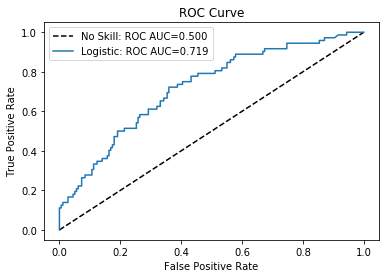

In [844]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, NNpredictions[:, 1])

lr_auc = roc_auc_score(y_test, NNpredictions[:, 1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='No Skill: ROC AUC=%.3f' % (0.5))
plt.plot(fpr, tpr, label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [853]:
NN_model = nn_model(1e-4)
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

optimizer = Adam(learning_rate=5e-5)
NN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
nb_epochs = 200
NN_model.fit(X_train, y_train_categorical, epochs=nb_epochs, batch_size=32)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_51 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_52 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_53 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_54 (Dense)             (None, 2)                 514       
Total params: 168,962
Trainable params: 168,962
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples
Epoch 1/200
750/750 [==============================] - 2s 2ms/sample - loss: 0.6930 - acc: 0

Epoch 72/200
750/750 [==============================] - 0s 380us/sample - loss: 0.5111 - acc: 0.7487
Epoch 73/200
750/750 [==============================] - 0s 333us/sample - loss: 0.5099 - acc: 0.7493
Epoch 74/200
750/750 [==============================] - 0s 339us/sample - loss: 0.5090 - acc: 0.7500
Epoch 75/200
750/750 [==============================] - 0s 359us/sample - loss: 0.5079 - acc: 0.7540
Epoch 76/200
750/750 [==============================] - 0s 350us/sample - loss: 0.5071 - acc: 0.7500
Epoch 77/200
750/750 [==============================] - 0s 337us/sample - loss: 0.5061 - acc: 0.7520
Epoch 78/200
750/750 [==============================] - 0s 338us/sample - loss: 0.5053 - acc: 0.7540
Epoch 79/200
750/750 [==============================] - 0s 358us/sample - loss: 0.5043 - acc: 0.7553
Epoch 80/200
750/750 [==============================] - 0s 316us/sample - loss: 0.5034 - acc: 0.7520
Epoch 81/200
750/750 [==============================] - 0s 353us/sample - loss: 0.5025 - ac

750/750 [==============================] - 0s 380us/sample - loss: 0.3540 - acc: 0.8460
Epoch 33/200
750/750 [==============================] - 0s 348us/sample - loss: 0.3518 - acc: 0.8447
Epoch 34/200
750/750 [==============================] - 0s 389us/sample - loss: 0.3504 - acc: 0.8427
Epoch 35/200
750/750 [==============================] - 1s 1ms/sample - loss: 0.3433 - acc: 0.8487
Epoch 36/200
750/750 [==============================] - 0s 340us/sample - loss: 0.3382 - acc: 0.8507
Epoch 37/200
750/750 [==============================] - 0s 434us/sample - loss: 0.3355 - acc: 0.8507
Epoch 38/200
750/750 [==============================] - 0s 460us/sample - loss: 0.3307 - acc: 0.8573
Epoch 39/200
750/750 [==============================] - 0s 366us/sample - loss: 0.3309 - acc: 0.8627
Epoch 40/200
750/750 [==============================] - 1s 674us/sample - loss: 0.3231 - acc: 0.8647
Epoch 41/200
750/750 [==============================] - 1s 845us/sample - loss: 0.3189 - acc: 0.8660
Epoch

750/750 [==============================] - 0s 615us/sample - loss: 0.0448 - acc: 0.9893
Epoch 194/200
750/750 [==============================] - 0s 522us/sample - loss: 0.0464 - acc: 0.9867
Epoch 195/200
750/750 [==============================] - 0s 521us/sample - loss: 0.0459 - acc: 0.9867
Epoch 196/200
750/750 [==============================] - 0s 535us/sample - loss: 0.0434 - acc: 0.9893
Epoch 197/200
750/750 [==============================] - 0s 520us/sample - loss: 0.0434 - acc: 0.9907
Epoch 198/200
750/750 [==============================] - 0s 566us/sample - loss: 0.0421 - acc: 0.9840
Epoch 199/200
750/750 [==============================] - 0s 531us/sample - loss: 0.0439 - acc: 0.9813
Epoch 200/200
750/750 [==============================] - 0s 561us/sample - loss: 0.0419 - acc: 0.9913


In [854]:
NNpredictions = NN_model.predict(X_test)

NN_prediction = list()
for i in range(len(NNpredictions)):
    NN_prediction.append(np.argmax(NNpredictions[i]))

In [855]:
# Validation of the results
print(accuracy_score(y_test, NN_prediction))
print("\n")
print(confusion_matrix(y_test, NN_prediction))
print("\n")
print(fbeta_score(y_test, NN_prediction, beta=2))
print("\n")
print(classification_report(y_test, NN_prediction))

0.692


[[144  34]
 [ 43  29]]


0.41310541310541304


              precision    recall  f1-score   support

           0       0.77      0.81      0.79       178
           1       0.46      0.40      0.43        72

    accuracy                           0.69       250
   macro avg       0.62      0.61      0.61       250
weighted avg       0.68      0.69      0.69       250



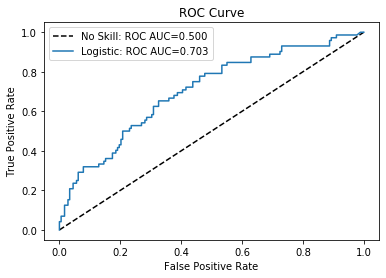

In [856]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, NNpredictions[:, 1])

lr_auc = roc_auc_score(y_test, NNpredictions[:, 1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='No Skill: ROC AUC=%.3f' % (0.5))
plt.plot(fpr, tpr, label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## SVM model

In [51]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
SVMpredictions = clf.predict(X_test)

In [53]:
# Validation of the results
print(accuracy_score(y_test,SVMpredictions))
print("\n")
print(confusion_matrix(y_test, SVMpredictions))
print("\n")
print(fbeta_score(y_test, SVMpredictions, beta=2))
print("\n")
print(classification_report(y_test, SVMpredictions))

0.756


[[164  14]
 [ 47  25]]


0.382262996941896


              precision    recall  f1-score   support

           0       0.78      0.92      0.84       178
           1       0.64      0.35      0.45        72

    accuracy                           0.76       250
   macro avg       0.71      0.63      0.65       250
weighted avg       0.74      0.76      0.73       250

